# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Описание данных
**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:

Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:**

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## 1. Подготовка данных

Загрузим наши данные и ознакомимся с ними.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_predict

In [2]:
full_data = pd.read_csv('gold_recovery_full.csv')
train = pd.read_csv('gold_recovery_train.csv')
test = pd.read_csv('gold_recovery_test.csv')

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Проверим правильность расчета эффективности обогащения. Посчитаем на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Добавим столбец с результатами эффективности обогащения.

Избавимся от пропусков.

In [4]:
train.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [5]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [6]:
calculation = ((C * (F - T)) / (F * (C - T))) * 100

In [7]:
old_recovery = train['rougher.output.recovery']

In [8]:
print('MAE:', mean_absolute_error(old_recovery, calculation))

MAE: 9.444891926100695e-15


Среднее абсолютное отклонение достаточно мало. Различий не наблюдаем, рассчеты считаем верными.

Сравним наполнение обучающей и тестовой выборок.

In [9]:
print(train.shape)
print(test.shape)

(14287, 87)
(5856, 53)


В обущающей выборке признаков гораздо больше. Проанализируем те признаки, которые недоступны в тестовой выборке.

In [10]:
missing_cols = train.columns.drop(test.columns)
missing_cols

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

По типам отсутствующих признаков, мы видим, что в test отсутствуют признаки, относящиеся к выходам из процессов обработки сырья/дальнейшей фракции, что объяснимо. Именно данные признаки мы и будем предсказывать в нашем проекте в будущем.

In [11]:
cols_to_drop = missing_cols.drop(['final.output.recovery', 'rougher.output.recovery'])
right_cols = train.columns.drop(cols_to_drop)
train = train[right_cols]

Обучающая выборка готова, теперь перейдем к тестовой. Столбец date в исходных данных содержит уникальные значения. Будем использовать эти значения как индексы, чтобы объединить датасеты и добавить в тестовую выборку недостающую информацию.

In [12]:
target_features_to_join = full_data[['date', 'final.output.recovery', 'rougher.output.recovery']].copy()

In [13]:
test = test.join(target_features_to_join.set_index('date'), on='date')

In [14]:
train['final.output.recovery'].isnull().value_counts()

False    14149
True       138
Name: final.output.recovery, dtype: int64

In [15]:
test['final.output.recovery'].isnull().value_counts()

False    5414
True      442
Name: final.output.recovery, dtype: int64

Избавимся от значений NaN.

In [16]:
train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)
test.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)

Пропуски в признаках заполним ближайшими значениями.

In [17]:
train=train.fillna(method='ffill')
test=test.fillna(method='ffill')

In [18]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [19]:
print(train.shape)
print(test.shape)

(14149, 55)
(5290, 55)


Первый этап пройден, подготовлены обучающая и тестовая выборки для дальнейшей работы.

## 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [20]:
processes = ['rougher.input.feed_', 
             'rougher.output.concentrate_', 
             'primary_cleaner.output.concentrate_', 
             'final.output.concentrate_']

metals = ['au', 'pb', 'ag']

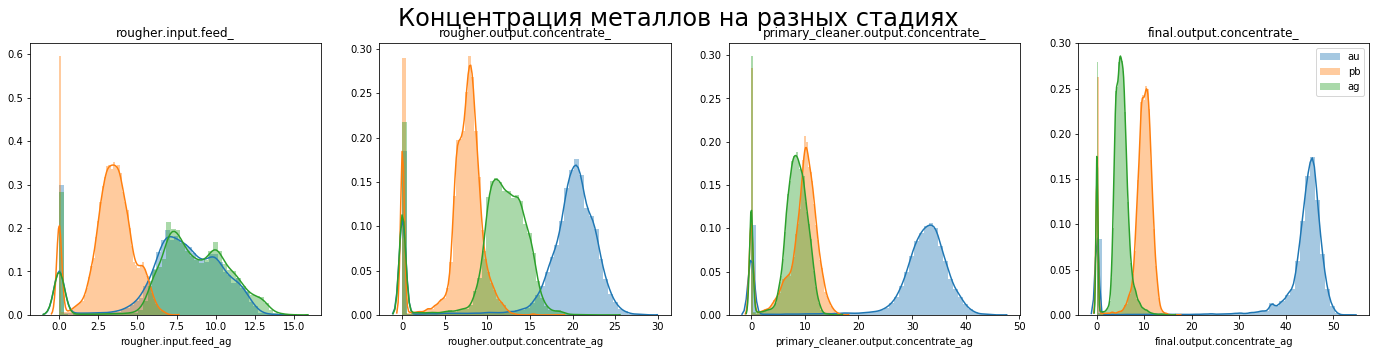

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(24,5)) 
fig.suptitle('Концентрация металлов на разных стадиях', fontsize=24);
for process, ax in zip(processes, axes):
    ax.set_title(process)
    for metal in metals:        
        columns = process+metal
        sns.distplot(full_data.loc[:, columns], label=metal, ax=ax)    
plt.legend(loc='best')
plt.show();

По полученным данным мы видим, что при прохождении изначальной фракции по производственным цепочкам, концентрация золота значительно увеличивается. Для серебра концентрация ко второй очистке меньше,чем было изначально. Доля свинца после первой и второй очистки не сильно изменилась.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

In [22]:
train_feed_size = train['rougher.input.feed_size']
test_feed_size = test['rougher.input.feed_size']

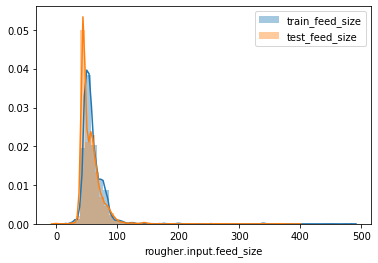

In [23]:
sns.distplot(train_feed_size, label='train_feed_size')
sns.distplot(test_feed_size, label='test_feed_size')
plt.legend();

Визуально кажется, что распределения похожи, небольшие неточности не должны критично повлиять на работу модели.

Изучим суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [24]:
concentrate_data = full_data[['date','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].copy()
concentrate_data['conc_sum_rougher'] = concentrate_data['rougher.input.feed_ag'] + concentrate_data['rougher.input.feed_pb'] + concentrate_data['rougher.input.feed_sol'] + concentrate_data['rougher.input.feed_au']
concentrate_data['conc_sum_primary'] = concentrate_data['primary_cleaner.output.concentrate_ag'] + concentrate_data['primary_cleaner.output.concentrate_pb'] + concentrate_data['primary_cleaner.output.concentrate_sol'] + concentrate_data['primary_cleaner.output.concentrate_au']
concentrate_data['conc_sum_final'] = concentrate_data['final.output.concentrate_ag'] + concentrate_data['final.output.concentrate_pb'] + concentrate_data['final.output.concentrate_sol'] + concentrate_data['final.output.concentrate_au']

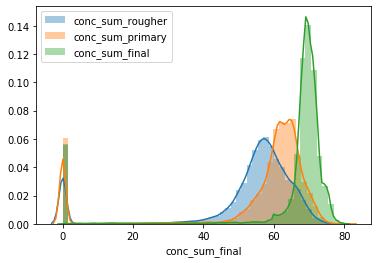

In [25]:
sns.distplot(concentrate_data['conc_sum_rougher'], label='conc_sum_rougher')
sns.distplot(concentrate_data['conc_sum_primary'], label='conc_sum_primary')
sns.distplot(concentrate_data['conc_sum_final'], label='conc_sum_final')
plt.legend();

Видим, что в суммарных данных много нулевых или близких к нулю значений. Необходимо избавиться от наблюдений с такими аномалиями, чтобы они не повлияли на качество модели.

In [26]:
anomaly = (concentrate_data[['date', 'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
           .copy()
           .query('conc_sum_rougher == 0 or conc_sum_primary == 0 or conc_sum_final == 0')
           .fillna(0))

In [27]:
anomaly.head()

,date,conc_sum_rougher,conc_sum_primary,conc_sum_final
19,2016-01-15 19:00:00,56.005644,0.0,64.546766
22,2016-01-15 22:00:00,56.038252,0.0,64.554911
30,2016-01-16 06:00:00,57.764677,0.0,63.765751
73,2016-01-18 01:00:00,56.626743,0.0,65.773298
76,2016-01-18 04:00:00,56.369424,0.0,59.902215


Избавимся от аномальных значений в тестовой выборке.

In [28]:
test = test.join(anomaly.set_index('date'), on='date')

In [29]:
test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))

In [30]:
test = test.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')

Проверим, что все правильно - значением всех признаков должно быть -1.

C:\ProgramData\Anaconda 3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda 3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda 3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


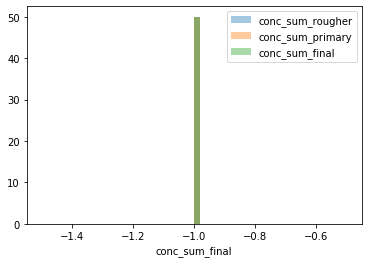

In [31]:
sns.distplot(test['conc_sum_rougher'], label='conc_sum_rougher')
sns.distplot(test['conc_sum_primary'], label='conc_sum_primary')
sns.distplot(test['conc_sum_final'], label='conc_sum_final')
plt.legend();

In [32]:
test.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

Удалим аномальные значения из обучающей выборки.

In [33]:
train = train.join(anomaly.set_index('date'), on='date')
train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))
train = train.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')
train.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

In [34]:
test.dropna(inplace=True)
train.dropna(inplace=True)

In [35]:
print(train.shape)
print(test.shape)

(14019, 55)
(5218, 55)


Все готово,можно перейти к построению модели.

## 3. Модель

Добавим функцию для рассчета метрики качества модели - sMAPE.

In [36]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

А также функцию для рассчета итогового sMAPE

In [37]:
def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

In [38]:
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']

features_train = train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

In [39]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

In [40]:
model_dtr = DecisionTreeRegressor(random_state=666)

dtr_rougher = model_dtr.fit(features_train, target_rougher)
dtr_final = model_dtr.fit(features_train, target_final)

predicted = cross_val_predict(dtr_rougher, features_train, target_rougher) 
predicted_1 = cross_val_predict(dtr_final, features_train, target_final) 

In [43]:
smape_dtr=smape(target_rougher,predicted)
smape_dtr

19.633637933491247

In [44]:
smape_dtr_final=smape(target_final,predicted_1)
smape_dtr_final

15.561671400722881

In [45]:
model_lr = LinearRegression()
lr_rougher = model_lr.fit(features_train, target_rougher)
lr_final = model_lr.fit(features_train, target_final)

predicted = cross_val_predict(lr_rougher, features_train, target_rougher) 
predicted_1 = cross_val_predict(lr_final, features_train, target_final) 

In [46]:
smape_lr=smape(target_rougher,predicted)
smape_lr

12.83359563960739

In [47]:
smape_lr_final=smape(target_final,predicted_1)
smape_lr_final

10.94811694955391

In [48]:
model_rf = RandomForestRegressor(random_state=666, n_estimators=10)

rf_rougher = model_rf.fit(features_train, target_rougher)
rf_final = model_rf.fit(features_train, target_final)

predicted = cross_val_predict(rf_rougher, features_train, target_rougher) 
predicted_1 = cross_val_predict(rf_final, features_train, target_final)

In [49]:
smape_rf=smape(target_rougher,predicted)
smape_rf

14.511238834787811

In [50]:
smape_rf_final=smape(target_final,predicted_1)
smape_rf_final

10.82741179218947

In [51]:
model_rf_1 = RandomForestRegressor(random_state=666, n_estimators=30)

rf_rougher_1 = model_rf_1.fit(features_train, target_rougher)
rf_final_1 = model_rf_1.fit(features_train, target_final)

predictedd= cross_val_predict(rf_rougher_1, features_train, target_rougher) 
predictedd_1 = cross_val_predict(rf_final_1, features_train, target_final)

In [52]:
smape_rf_1=smape(target_rougher,predictedd)
smape_rf_1

13.545860850627736

In [53]:
smape_rf_final_1=smape(target_final,predictedd_1)
smape_rf_final_1

10.13503696235544

Лучший результат показывает модель LinearRegression. Обучим её

In [54]:
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

features_test = test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

In [55]:
features_test = scaler.transform(features_test)

In [56]:
model_lr = LinearRegression()
model_lr_1 = LinearRegression()

lr_rougher = model_lr.fit(features_train, target_rougher)
lr_final = model_lr_1.fit(features_train, target_final)

lr_predictions_rougher = lr_rougher.predict(features_test)
lr_predictions_final = lr_final.predict(features_test)

In [57]:
smape_rougher = smape(target_rougher_test, lr_predictions_rougher)

In [58]:
smape_final = smape(target_final_test, lr_predictions_final)

In [59]:
final_smape(smape_rougher, smape_final)

8.480339749511925

Проверим качество модели, сравнив с константной, используя модель DummyRegressor.

In [60]:
dummy = DummyRegressor(strategy = 'mean')
dummy_1 = DummyRegressor(strategy = 'mean')

dummy_rougher = dummy.fit(features_train, target_rougher)
dummy_predictions_rougher = dummy_rougher.predict(features_test)

dummy_final = dummy_1.fit(features_train, target_final)
dummy_predictions_final = dummy_final.predict(features_test)

<div class="alert alert-block alert-info">
<b>Комментарий v2:</b>    
Можно было сразу использовать dummy_rougher(final):
    
    dummy_rougher = DummyRegressor(strategy = 'mean')
    dummy_rougher.fit(features_train, target_rougher)
    dummy_predictions_rougher = dummy_rougher.predict(features_test)
</div>

In [61]:
smape_rougher_dummy = smape(target_rougher_test, dummy_predictions_rougher)

In [62]:
smape_final_dummy = smape(target_final_test, dummy_predictions_final)

In [63]:
final_smape(smape_rougher_dummy, smape_final_dummy)

9.05393083680066

**Вывод**

Мы обработали исходные данные и построили модель при помощи LinearRegression, в результате получили  конечный результат по обогащению золота изначального сырья со средним отклонением ошибки предсказания - 8.48%, что можно считать неплохим результатом. Также проверили модель на адекватность при помощи DummyRegressor и получили значение хуже, чем у нашей обученная модели. Следовательно обученная модель предсказывает результаты лучше.